# SQL Portfolio Project

# Introduction

The purpose of this portfolio project is to demonstrate my Structured Query Language (SQL) technical skills. Specifically, I want to show my knowledge of relational database (DB) architecture and ability to query and manipulate databases using SQL Data Manipulation Language (DML) and Data Definition Language (DDL).

This Jupyter Notebook will begin with importing a single dataset into a new SQLite database then I will explore, expand, and evaluate. Python code is used to get the notebook up and running but I will stick to using SQL commands whenever possible.

## Outline:
1. Create Database
2. Explore: SQL queries round 1
3. Expand Database
4. Explore: SQL Queries Round 2
5. Evaluate

## Data description

The data I'll explore comes from a portion of my PhD dissertation work. This dataset includes estimates of dissolved CO<sub>2</sub> (also referred to as *p*CO<sub>2</sub>) values in flowing fresh waters across the Contiguous United States from 1990 through 2020. The *p*CO<sub>2</sub> estimates come from using additional water quality parameters collected in flowing freshwater locations across the US. The purpose of this dataset is not to get into the details regarding carbon dynamics but to showcase my SQL skills. Therefore, I will include some explanation, when necessary, but I will keep it brief. Further details about the dataset's creation can be found in my published [data paper](https://ttoavs.github.io/publication/CDFLOW).

# 1. Create Database

First, we need to do some setup by loading SQLite into the environment, importing the module, and creating the database. If interested the data can be downloaded [here](https://doi.org/10.6084/m9.figshare.19787326.v2)

In [1]:
# Load
%load_ext sql

# Import
import sqlite3

# Create Database
con = sqlite3.connect("CDFLOW.db")
cur = con.cursor()

# Connect to Database
%sql sqlite:///CDFLOW.db

Next, I will read in the dataset and do a few manipulations before adding it to the created SQLite DB. The manipulations performed are primarily to narrow down the size of the dataset so that SQLite can handle it. One of the great things about using SQL-based relational DBs is their ability to process big data, but SQLite as the name implies is for smaller relational DBs. However, in this environment, SQLite is great for learning and showcasing technical SQL skills.

In [2]:
# import pandas
import pandas as pd

# read in data
df = pd.read_csv("Data/CDFLOW.csv", index_col=False)

# filter data to 2018-2020
df = df.loc[(df["Date"] >= "2018-01-01") & (df["Date"] < "2019-12-31")]

# filter for observations with greater than 1000 alkalinity
df = df.loc[(df["Alkalinity.ueq/kgw"] > 1000)]

# filter for observations with less than 10000 pCO2
df = df.loc[(df["pCO2.uatm"] < 10000)]

# Filter out alks over 5000
df = df.loc[(df["Alkalinity.ueq/kgw"] < 5000)]

# drop some unnecessary columns
df = df.drop(columns=["Time", "CO2.mg/l"])

# create id col
df["id"] = df["COMID"].astype(str) + "_" + df["Date"]

# Make HUC12 string
df["HUC_12"] = df["HUC_12"].astype(str)

# Add leading zeros
df["HUC_12"] = df["HUC_12"].str.zfill(12)

Now, I can add the dataset to the SQLite DB and create the first table.

In [3]:
df.to_sql("CDFLOWTBL", con, if_exists="replace", index=False, method="multi")

In [4]:
%sql CREATE TABLE CDFLOW AS SELECT * FROM CDFLOWTBL

 * sqlite:///CDFLOW.db
Done.


[]

Lets take a look at the table and see the features that are included.

In [5]:
%sql PRAGMA table_info(CDFLOW)

 * sqlite:///CDFLOW.db
Done.


cid,name,type,notnull,dflt_value,pk
0,COMID,INT,0,None,0
1,Date,TEXT,0,None,0
2,HUC_12,TEXT,0,None,0
3,State,TEXT,0,None,0
4,Temp.C,REAL,0,None,0
5,pH.std_units,REAL,0,None,0
6,Alkalinity.ueq/kgw,REAL,0,None,0
7,pCO2.uatm,REAL,0,None,0
8,id,TEXT,0,None,0


Displayed above are the 8 features of the SQL table. For some context, the following table describes each of the features. Also, note that id is not directly assigned as the PK in the SQLite DB, but it would be in a real working environment.

Feature Name            | Description
------------            | -----------
id (Primary Key)        | Unique observation id (COMID & Date)
COMID                   | Specific stream catchment segment, sampling site
Date                    | Date of measurments
HUC_12                  | HUC12 watershed where measurments occured
State                   | US state where measurments occured
Temp.C                  | Temperature of water (used to estimate *p*CO<sub>2</sub>)
pH.std_units            | pH of water (used to estimate *p*CO<sub>2</sub>)
Alkalinity.ueq.kgw      | Alkalinity of water (used to estimate *p*CO<sub>2</sub>)
*p*CO<sub>2</sub>.uatm  | partial pressure of CO2 in water (estimate)




# 2. Explore: SQL Queries Round 1

Now that I have a DB to work with, we can dive in! I created 12 different prompts (tasks/questions) that require SQL queries. The prompts will guide the exploration of the DB.

1\. Of the three spatial grouping features how many unique groups are represented?

In [6]:
%sql SELECT COUNT(DISTINCT(State)) AS State, COUNT(DISTINCT(HUC_12)) AS HUC_12, COUNT(DISTINCT(COMID)) AS COMID FROM CDFLOW

 * sqlite:///CDFLOW.db
Done.


State,HUC_12,COMID
46,2669,3437


2\. How many observations are available in each of the 46 states represented in the data? Which state has the least?

In [7]:
%sql SELECT COUNT("pCO2.uatm") AS Count, State FROM CDFLOW GROUP BY State ORDER By Count ASC LIMIT 5

 * sqlite:///CDFLOW.db
Done.


Count,State
25,WV
26,MA
37,MD
39,NC
46,KY


3\. What is the mean, max, and min value from each state?

In [8]:
%sql SELECT round(avg("pCO2.uatm"),0) AS Mean, round(min("pCO2.uatm"),0) AS Min, round(max("pCO2.uatm"),0) AS Max, State FROM CDFLOW GROUP BY State LIMIT 5

 * sqlite:///CDFLOW.db
Done.


Mean,Min,Max,State
2668.0,0.0,9976.0,AL
1907.0,218.0,6860.0,AR
1448.0,88.0,7794.0,AZ
1529.0,262.0,8950.0,CA
1713.0,0.0,9943.0,CO


4\. How many observations have pH values over 7?

In [9]:
%sql SELECT count(COMID) FROM CDFLOW WHERE "pH.std_units" > 7

 * sqlite:///CDFLOW.db
Done.


count(COMID)
24773


5\. Which 5 States have the lowest average temperatures?

In [10]:
%sql SELECT avg("Temp.C") AS mean, State FROM CDFLOW GROUP BY State ORDER BY mean ASC LIMIT 5

 * sqlite:///CDFLOW.db
Done.


mean,State
9.521993174061434,WY
10.960207705192627,MT
11.254255319148935,NV
11.579574829931975,ND
12.166875993640707,UT


6\. How many observations have above-average pCO2 values?

In [11]:
%sql SELECT COUNT("pCO2.uatm") FROM CDFLOW WHERE "pCO2.uatm" > ( SELECT avg("pCO2.uatm") FROM CDFLOW)

 * sqlite:///CDFLOW.db
Done.


"COUNT(""pCO2.uatm"")"
8711


7\. How many observations occur in each month?

In [12]:
%sql SELECT strftime('%m', Date) AS MONTH, count("pCO2.uatm") AS COUNT FROM CDFLOW GROUP BY strftime('%m', Date)

 * sqlite:///CDFLOW.db
Done.


MONTH,COUNT
01,1080
02,1347
03,1795
04,2165
05,2662
06,2665
07,2833
08,2702
09,2837
10,2363


8\. What is the average *p*CO<sub>2</sub> value in Florida during the summer?

In [13]:
%sql SELECT avg("pCO2.uatm") AS value FROM CDFLOW WHERE State = "FL" AND strftime('%m', Date) + 0 > 5 AND strftime('%m', Date) + 0 < 9

 * sqlite:///CDFLOW.db
Done.


value
2475.4609601426464


9\. What are the average HUC_12 pH values in Minnesota?

In [14]:
%sql SELECT round(avg("pH.std_units"),2) AS value, HUC_12 FROM CDFLOW WHERE State = "MN" GROUP BY HUC_12 LIMIT 5

 * sqlite:///CDFLOW.db
Done.


value,HUC_12
7.55,040102010702
8.1,040102010708
7.6,040102010905
7.8,040102011005
7.78,040102011301


10\. List COMIDS that have *p*CO<sub>2</sub> values with pH > 9, Alkalinity < 2500, and temperature > 25?

In [15]:
%sql SELECT Distinct(COMID) AS COMID FROM CDFLOW WHERE "pH.std_units" > 9 AND "Temp.C" > 25 AND "Alkalinity.ueq/kgw" > 2500

 * sqlite:///CDFLOW.db
Done.


COMID
15673383
15668481
15667791
18503223
18506684
18509098
18508618
20100836
10206599
10083026


11\. Compute a running count of observations by date in each COMID.

In [16]:
# Window Function
%sql SELECT COMID, Date, COUNT(COMID) OVER (PARTITION BY COMID ORDER BY Date) AS running_count FROM CDFLOW LIMIT 20

 * sqlite:///CDFLOW.db
Done.


COMID,Date,running_count
12664,2018-05-08,1
12782,2018-08-13,1
12932,2018-02-07,1
12932,2018-03-07,2
12932,2018-04-10,3
12932,2018-05-08,4
12932,2018-07-10,5
12932,2018-08-07,6
12932,2018-09-11,7
12932,2018-10-09,8


12\. Write a query to look at the difference between the most recent *p*CO<sub>2</sub> value from the last at a particular COMID

In [17]:
%sql SELECT COMID, Date, "pCO2.uatm" - LAG("pCO2.uatm") OVER (PARTITION BY COMID ORDER BY Date) AS Diff_from_last FROM CDFLOW LIMIT 20

 * sqlite:///CDFLOW.db
Done.


COMID,Date,Diff_from_last
12664,2018-05-08,None
12782,2018-08-13,None
12932,2018-02-07,None
12932,2018-03-07,1857.9879503609927
12932,2018-04-10,1039.9338534680805
12932,2018-05-08,-2755.134288795467
12932,2018-07-10,153.46667503441495
12932,2018-08-07,-330.90376550833196
12932,2018-09-11,316.082374222451
12932,2018-10-09,241.050592129013


# 3. Expand

Now, that we've written some SQL code and explored that database we can do some SQL tasks with more purpose!

The feature that is of most interest is the estimate of *p*CO<sub>2</sub>. But looking at the other features I am also interested in grouping the estimates at the watershed level. If you're not familiar with watersheds, they are an area of land where all water drains to the same locations. Across the US watersheds are divided into Hydrological Units and classified by Hydrological Unit Codes (HUCs), which range from HUC12 to HUC2 going in 2-digit increments. Each HUC going from HUC12 to HUC2 gets larger and follows a nested system of classification. So, if you know the HUC12, you know each HUC to HUC2 that the observations fall into. A common watershed level that water is managed and studied across the US is at the HUC8 level and I am interested in grouping the data at that level. 

Knowing that I can get HUC8 from HUC12 I can create a new HUC8 feature using SQL.

In [18]:
# First create new HUC_8 column
%sql ALTER TABLE CDFLOW ADD COLUMN HUC_8 TEXT

# Populate column with substring of the HUC12 column
%sql UPDATE CDFLOW SET HUC_8 = substr(HUC_12,1,8)

# Test to make sure it worked
%sql SELECT DISTINCT(HUC_8), HUC_12 FROM CDFLOW LIMIT 5

 * sqlite:///CDFLOW.db
Done.
 * sqlite:///CDFLOW.db
25012 rows affected.
 * sqlite:///CDFLOW.db
Done.


HUC_8,HUC_12
17020015,170200150903
17020016,170200160305
17020016,170200160306
17020015,170200151010
17020015,170200150406


Now that we have this new feature in the table, I am interested in expanding the DB so that it is more comprehensive. I want to add a table with HUC8 environmental data. This new table will be linked to the old *via* foreign key HUC_8.

The HUC8 environmental data comes from the Environmental Protection Agencies Watershed Index Online (WSIO) Indicator Data Library ([link](https://www.epa.gov/wsio/wsio-indicator-data-library)). The specific HUC8 environmental variable I am interested in is the percent of land within each HUC8 classified under different land use classifications. 

To do this I first read in the datasets with Python and combined them to one dataset.

In [19]:
# Read in HUC8 landcover data

import os

file_list = os.listdir("data/WSIO_HUC8/")

HUC8_df = pd.DataFrame()
for file in file_list:
    temp = pd.read_excel(
        "data/WSIO_HUC8/" + file,
        sheet_name="WSIO_REGIONAL_DATA_TABLE",
        engine="openpyxl",
        usecols=[
            "Hydrologic Unit Code 8-Digit (HUC8)",
            "% Forest in WS (2016)",
            "% Shrub/Scrub in WS (2016)",
            "% Grassland/Herbaceous in WS (2016)",
            "% Wetlands in WS (2016)",
            "% Open Water in WS (2016)",
            "% Perennial Ice/Snow in WS (2016)",
            "% Barren Land in WS (2016)",
            "% Urban in WS (2016)",
            "% Agriculture in WS (2016)",
        ],
    )
    HUC8_df = HUC8_df.append(temp)

HUC8_df = HUC8_df.drop_duplicates(subset=["Hydrologic Unit Code 8-Digit (HUC8)"])
HUC8_df = HUC8_df.rename(columns={"Hydrologic Unit Code 8-Digit (HUC8)": "HUC_8"})  # rename
HUC8_df["HUC_8"] = HUC8_df["HUC_8"].astype(str)  # Change col type
HUC8_df["HUC_8"] = HUC8_df["HUC_8"].str.zfill(8)  # adding leanding zeros

In [20]:
# Some setup
import warnings
warnings.filterwarnings('ignore')

HUC8_df.to_sql("HUC8TBL", con, if_exists="replace", index=False, method="multi")
%sql CREATE TABLE Landcover AS SELECT * FROM HUC8TBL

 * sqlite:///CDFLOW.db
Done.


[]

# 4. Explore: SQL Queries Round 2

Now that I have landcover data I can explore the data a bit further using multiple tables. Note the landcover table has HUC8 data from all HUC8 across the US while the CDFLOW table only has particular HUC8s.

Like before I will list some prompts to lead further exploration of the DB. Note, that these prompts are more complex than before.

1\. Rename the land cover table columns to be more user-friendly.

In [21]:
# This task is long and clunky so I had to do it a different way.
rename_queries = [
    "ALTER TABLE Landcover RENAME COLUMN '% Forest in WS (2016)' TO Forest;",
    "ALTER TABLE Landcover RENAME COLUMN '% Shrub/Scrub in WS (2016)' TO Shrub;",
    "ALTER TABLE Landcover RENAME COLUMN '% Grassland/Herbaceous in WS (2016)' TO Grassland;",
    "ALTER TABLE Landcover RENAME COLUMN '% Wetlands in WS (2016)' TO Wetlands;",
    "ALTER TABLE Landcover RENAME COLUMN '% Open Water in WS (2016)' TO Open_Water;",
    "ALTER TABLE Landcover RENAME COLUMN '% Perennial Ice/Snow in WS (2016)' TO Ice_and_Snow;",
    "ALTER TABLE Landcover RENAME COLUMN '% Barren Land in WS (2016)' TO Barren;",
    "ALTER TABLE Landcover RENAME COLUMN '% Urban in WS (2016)' TO Urban;",
    "ALTER TABLE Landcover RENAME COLUMN '% Agriculture in WS (2016)' TO Agriculture;",
]

for query in rename_queries:
    con.execute(query)

2\. Query CO2 data with the land cover data.

In [22]:
# Left join
%sql SELECT HUC_8, "pCO2.uatm" FROM CDFLOW LEFT JOIN Landcover ON CDFLOW.HUC_8 = Landcover.HUC_8 LIMIT 5

 * sqlite:///CDFLOW.db
Done.


COMID,Date,HUC_12,State,Temp.C,pH.std_units,Alkalinity.ueq/kgw,pCO2.uatm,id,HUC_8,HUC_8_1,Forest,Shrub,Grassland,Wetlands,Open_Water,Ice_and_Snow,Barren,Urban,Agriculture
24407271,2018-02-14,170200150903,WA,4.7,8.6,3336.994,398.49838644954804,24407271_2018-02-14,17020015,17020015,0.0017229023873544,25.9511541765115,8.46795317515502,1.58900625791765,2.02023611886962,0.0,0.0467845038517374,3.66756892590063,58.2555739394065
24407271,2018-10-10,170200150903,WA,13.6,7.6,2098.11,2864.7799866996897,24407271_2018-10-10,17020015,17020015,0.0017229023873544,25.9511541765115,8.46795317515502,1.58900625791765,2.02023611886962,0.0,0.0467845038517374,3.66756892590063,58.2555739394065
24407271,2018-04-03,170200150903,WA,8.2,8.18,1998.2,668.1297441397,24407271_2018-04-03,17020015,17020015,0.0017229023873544,25.9511541765115,8.46795317515502,1.58900625791765,2.02023611886962,0.0,0.0467845038517374,3.66756892590063,58.2555739394065
24407271,2018-07-25,170200150903,WA,22.8,8.08,2198.02,1113.74822797132,24407271_2018-07-25,17020015,17020015,0.0017229023873544,25.9511541765115,8.46795317515502,1.58900625791765,2.02023611886962,0.0,0.0467845038517374,3.66756892590063,58.2555739394065
24407271,2019-10-15,170200150903,WA,10.0,8.1,2537.714,1038.6922232017,24407271_2019-10-15,17020015,17020015,0.0017229023873544,25.9511541765115,8.46795317515502,1.58900625791765,2.02023611886962,0.0,0.0467845038517374,3.66756892590063,58.2555739394065


3\. Query pCO2 estimates where over 50% of the HUC8 is covered by water.

In [23]:
# Subquery
%sql SELECT * FROM CDFLOW WHERE HUC_8 IN (select Landcover.HUC_8 FROM Landcover where Open_Water > 50) LIMIT 5

 * sqlite:///CDFLOW.db
Done.


COMID,Date,HUC_12,State,Temp.C,pH.std_units,Alkalinity.ueq/kgw,pCO2.uatm,id,HUC_8
932040370,2019-11-04,020402040000,GA,12.76,7.8,1420.7202,1216.2543842155499,932040370_2019-11-04,02040204
932040370,2019-03-11,020402040000,FL,4.24,7.87,1025.0766,680.623551996884,932040370_2019-03-11,02040204
932040370,2019-11-04,020402040000,FL,12.76,7.8,1420.7202,1216.2543842155499,932040370_2019-11-04,02040204
932040370,2019-08-27,020402040000,GA,23.14,7.63,1184.9326,1730.3671209455,932040370_2019-08-27,02040204
932040370,2019-09-09,020402040000,GA,23.46,7.56,1248.875,2152.51230110569,932040370_2019-09-09,02040204


4\. Check to see that all HUC8 in the CDFLOW table are represented in the landcover table.

In [24]:
%sql SELECT count(distinct(HUC_8)) FROM CDFLOW WHERE EXISTS (SELECT distinct(HUC_8) FROM Landcover)

# If you look at the original data frame there are 758 unique HUC8s to yes they are all there

 * sqlite:///CDFLOW.db
Done.


count(distinct(HUC_8))
758


5\. Find which HUC8s in the landcover table are represented in the CDFLOW table and return how many pCO2 estimates are available for each HUC8. Which HUC8 has the most data?

In [25]:
%sql SELECT distinct(HUC_8), count("pCO2.uatm") AS Obsv_Availible FROM CDFLOW WHERE EXISTS (SELECT distinct(HUC_8) FROM Landcover) GROUP BY HUC_8 ORDER BY Obsv_Availible DESC LIMIT 10

 * sqlite:///CDFLOW.db
Done.


HUC_8,Obsv_Availible
10190003,929
04040003,760
02040205,703
04110002,579
02050306,417
02050305,396
03150106,395
17010201,358
05120208,271
05120201,270


# 5. Evaluate

Finally, I would like to create a quick real example of how an SQL query can be implemented into a modeling procedure of this data.

I am interested in modeling how urban landcover might affect the average pCO2 in flowing freshwaters across HUC8 in the US. The actual science of this example is not important, but I think it's a good use case for using SQL to model data in Python.

First, I'll query the data and save it as a Pandas df.

In [26]:
# Query for data
mod_df = pd.read_sql_query(
    """SELECT * FROM Landcover LEFT JOIN (SELECT avg("pCO2.uatm") AS mean, HUC_8 FROM CDFLOW Group By HUC_8) CDFLOW ON Landcover.HUC_8 = CDFLOW.HUC_8 WHERE CDFLOW.HUC_8 IS NOT NULL""",
    con,
)

Next, let's take a quick look at the relationship I'm interested in.

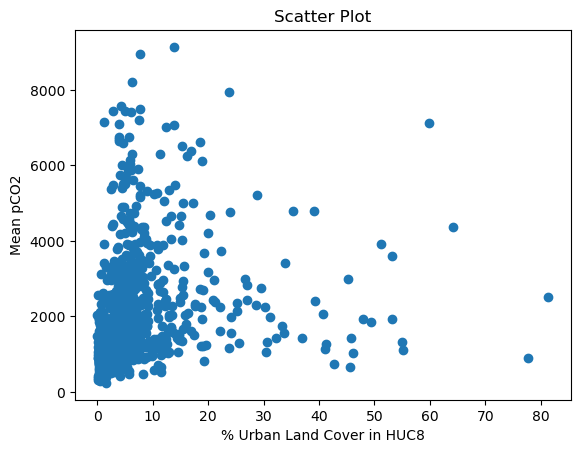

In [27]:
# visulize the data

import matplotlib.pyplot as plt

plt.scatter(x=mod_df["Urban"], y=mod_df["mean"])
plt.title("Scatter Plot")
plt.xlabel("% Urban Land Cover in HUC8")
plt.ylabel("Mean pCO2")
plt.show()

The relationship looks interesting and might make for an insightful linear model.

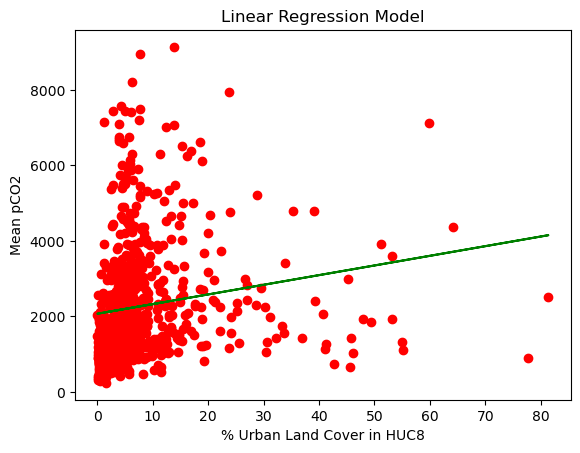

In [125]:
from sklearn.linear_model import LinearRegression
import numpy as np

x = np.array(mod_df["Urban"]).reshape(-1, 1)
y = np.array(mod_df["mean"]).reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)

plt.scatter(x, y, color="red")
plt.plot(x.reshape(-1, 1), model.predict(x), color="green")
plt.title("Linear Regression Model")
plt.xlabel("% Urban Land Cover in HUC8")
plt.ylabel("Mean pCO2")
plt.show()

Looks like there is a positive linear relationship! Of course, more statistical testing is needed but that's not the point of this exercise.

# Conclusion

Relational DBs are powerful, and SQL is a fundamental tool to fully utilize them. 

In summary, in this document, I created a relational DB then explored, expanded, and evaluated the data within.